In [1]:
import pandas as pd

# 1) Load your original data
df = pd.read_csv('filtered_v3.csv')

# 2) Extract baseline (eye_closure)
bands = ['delta','theta','alpha','beta','gamma']
baseline = (df[df['task']=='eye_closure']
              .loc[:, ['participant','condition'] + bands]
              .rename(columns={b: f'{b}_base' for b in bands}))

# 3) Merge baseline
df2 = df.merge(baseline, on=['participant','condition'], how='left')

# 4) Compute relative bands
for b in bands:
    df2[f'{b}_rel'] = df2[b] - df2[f'{b}_base']

# 5) Save corrected CSV
df2.to_csv('filtered_v3_with_baseline_corrected.csv', index=False)
print("Saved filtered_v3_with_baseline_corrected.csv")


Saved filtered_v3_with_baseline_corrected.csv


In [3]:
import pandas as pd
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

# === 1. Load the CSV ===
df = pd.read_csv("filtered_v3_with_baseline_corrected.csv")

# === 2. Focus only on non-eye_closure tasks ===
df = df[df['task'] != 'eye_closure']

# === 3. Define band columns (relative to baseline) ===
bands = ['delta_rel', 'theta_rel', 'alpha_rel', 'beta_rel', 'gamma_rel']

# === 4. Group by participant and condition (average all events per person) ===
grouped = df.groupby(['participant', 'condition'])[bands].mean().reset_index()

# === 5. Paired t-tests (within-subject: with vs. without nanoe) ===
with_data = grouped[grouped['condition'] == 'with'].sort_values('participant')
without_data = grouped[grouped['condition'] == 'without'].sort_values('participant')

print("=== Paired T-tests (with vs without nanoe) ===")
for band in bands:
    t_stat, p_val = stats.ttest_rel(with_data[band], without_data[band], nan_policy='omit')
    print(f"{band:<10} | t = {t_stat: .3f}, p = {p_val: .4f}")

# === 6. ANOVA (between-subject) to confirm significance ===
print("\n=== One-way ANOVA (condition effect per band) ===")
long_df = grouped.melt(id_vars=['participant', 'condition'],
                       value_vars=bands,
                       var_name='band',
                       value_name='value')

for band in bands:
    band_data = long_df[long_df['band'] == band]
    model = ols('value ~ C(condition)', data=band_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\n{band.upper()} band ANOVA:")
    print(anova_table)


=== Paired T-tests (with vs without nanoe) ===
delta_rel  | t = -0.378, p =  0.7104
theta_rel  | t = -1.243, p =  0.2318
alpha_rel  | t =  0.295, p =  0.7717
beta_rel   | t =  0.204, p =  0.8407
gamma_rel  | t =  1.695, p =  0.1095

=== One-way ANOVA (condition effect per band) ===

DELTA_REL band ANOVA:
                   sum_sq    df         F    PR(>F)
C(condition)    45.156951   1.0  0.148318  0.702696
Residual      9742.721933  32.0       NaN       NaN

THETA_REL band ANOVA:
                  sum_sq    df         F    PR(>F)
C(condition)    4.585664   1.0  0.616703  0.438051
Residual      237.944677  32.0       NaN       NaN

ALPHA_REL band ANOVA:
                   sum_sq    df         F    PR(>F)
C(condition)     0.352429   1.0  0.010133  0.920448
Residual      1113.016642  32.0       NaN       NaN

BETA_REL band ANOVA:
                sum_sq    df         F    PR(>F)
C(condition)  0.003868   1.0  0.031537  0.860168
Residual      3.924831  32.0       NaN       NaN

GAMMA_REL ban

In [4]:
import pandas as pd
import scipy.stats as stats

# === 1. Load data ===
df = pd.read_csv("filtered_v3_with_baseline_corrected.csv")

# === 2. Only include tasks where event exists (exclude eye_closure/opening) ===
df = df[df['task'] == 'driving']
bands = ['delta_rel', 'theta_rel', 'alpha_rel', 'beta_rel', 'gamma_rel']

# === 3. Identify all events present ===
unique_events = df['event'].dropna().unique()

# === 4. Loop through each event and run paired t-tests per band ===
print("=== Paired t-tests (with vs. without nanoe) per event per band ===\n")
for event in unique_events:
    print(f"Event: {event}")

    # Filter rows for current event
    df_event = df[df['event'] == event]

    # Pivot to get with/without side-by-side for each participant
    pivot = df_event.pivot_table(index='participant', columns='condition', values=bands)

    # Skip if not enough data
    if 'with' not in pivot.columns.levels[1] or 'without' not in pivot.columns.levels[1]:
        print("  Not enough data for both conditions\n")
        continue

    # Run paired t-tests for each band
    for band in bands:
        try:
            data_with = pivot[band]['with']
            data_without = pivot[band]['without']
            t_stat, p_val = stats.ttest_rel(data_with, data_without, nan_policy='omit')
            print(f"  {band:<10} | t = {t_stat: .3f}, p = {p_val: .4f}")
        except Exception as e:
            print(f"  {band:<10} | Error: {e}")

    print("")  # newline between events


=== Paired t-tests (with vs. without nanoe) per event per band ===

Event: pedestrian
  delta_rel  | t = -0.567, p =  0.5823
  theta_rel  | t = -1.197, p =  0.2563
  alpha_rel  | t = -0.269, p =  0.7930
  beta_rel   | t =  0.879, p =  0.3984
  gamma_rel  | t =  2.393, p =  0.0357

Event: gapacceptance
  delta_rel  | t = -0.628, p =  0.5430
  theta_rel  | t = -1.634, p =  0.1305
  alpha_rel  | t = -0.027, p =  0.9790
  beta_rel   | t =  1.038, p =  0.3214
  gamma_rel  | t =  2.312, p =  0.0412

Event: roadclosure
  delta_rel  | t =  0.361, p =  0.7258
  theta_rel  | t =  0.448, p =  0.6637
  alpha_rel  | t =  0.319, p =  0.7564
  beta_rel   | t =  1.831, p =  0.0969
  gamma_rel  | t =  2.108, p =  0.0612

Event: carfollowing
  delta_rel  | t =  0.584, p =  0.5739
  theta_rel  | t = -0.311, p =  0.7625
  alpha_rel  | t =  0.209, p =  0.8389
  beta_rel   | t =  0.153, p =  0.8821
  gamma_rel  | t =  2.044, p =  0.0713

Event: billboards
  delta_rel  | t = -1.012, p =  0.3451
  theta_rel  

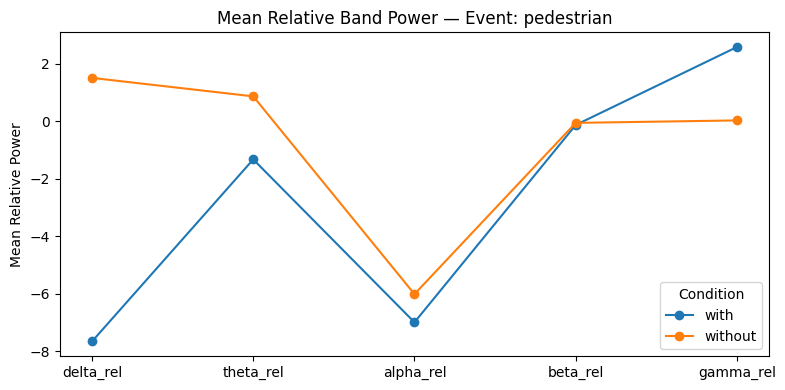

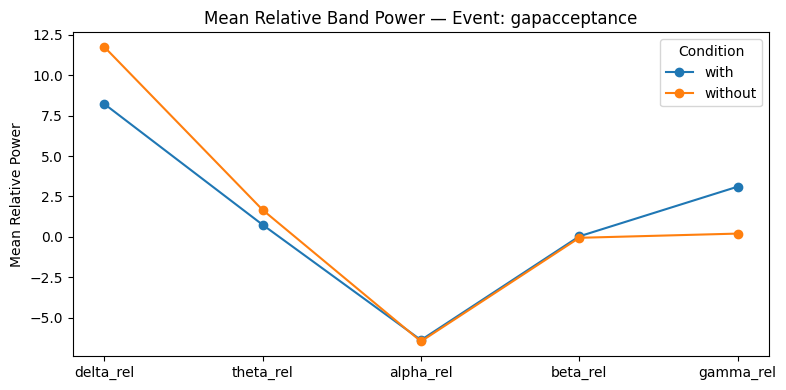

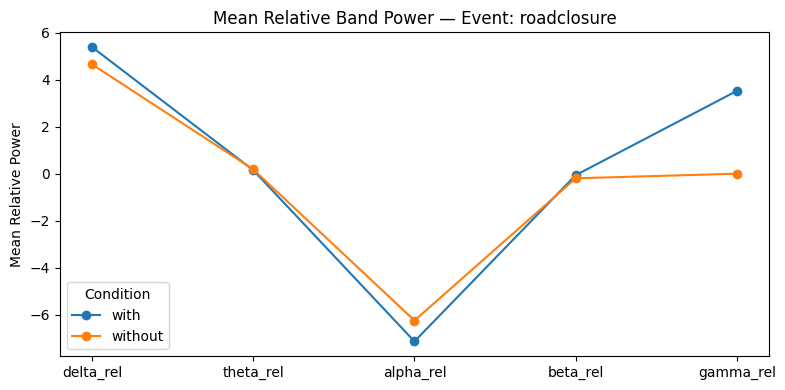

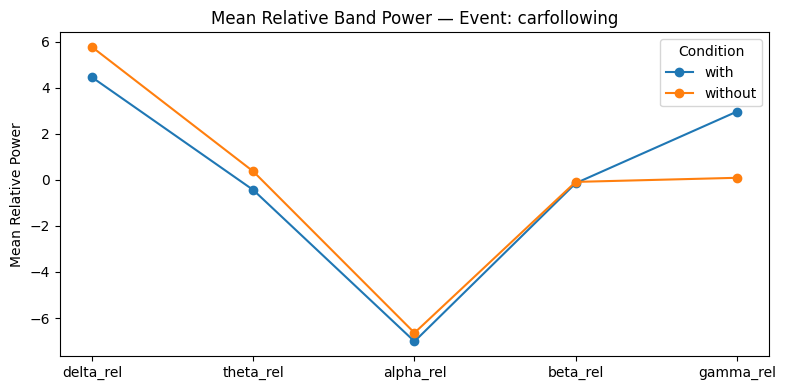

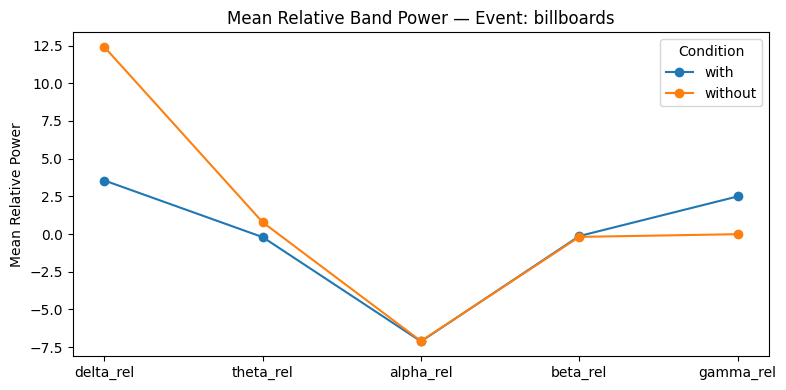

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your baseline‐corrected CSV
df = pd.read_csv("filtered_v3_with_baseline_corrected.csv")

# 2) Keep only driving‐task rows
df = df[df['task'] == 'driving']

# 3) List of relative bands
bands = ['delta_rel','theta_rel','alpha_rel','beta_rel','gamma_rel']

# 4) For each event, plot means for with/without
for event in df['event'].dropna().unique():
    sub = df[df['event']==event]
    # compute mean per condition
    means = sub.groupby('condition')[bands].mean().reindex(['with','without'])

    fig, ax = plt.subplots(figsize=(8, 4))
    for cond in ['with','without']:
        ax.plot(bands, means.loc[cond], marker='o', label=cond)

    ax.set_title(f"Mean Relative Band Power — Event: {event}")
    ax.set_ylabel("Mean Relative Power")
    ax.set_xticks(bands)
    ax.legend(title="Condition")
    plt.tight_layout()
    plt.show()
